# Necessary Library Imports

In [1]:
from platform import python_version
print('Python version ' + python_version())
import tensorflow as tf
print('Tensorflow version ' + tf.__version__)
from tensorflow import keras
print('Keras version ' + keras.__version__)
tf.config.list_physical_devices()
print(tf.config.list_physical_devices('GPU'))

import os
import numpy as np
import random
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from  keras.preprocessing.image import ImageDataGenerator
import segmentation_models as sm

Python version 3.9.13
Tensorflow version 2.9.2
Keras version 2.9.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Segmentation Models: using `keras` framework.


# Data preprocessing

## Defining function

In [2]:
def preprocessData(img, mask, BACKBONE, numClass):
    preprocessInput = sm.get_preprocessing(BACKBONE)
    img = preprocessInput(img)
    mask = to_categorical(mask, numClass)
    return img, mask

def trainGenerator(imgPath, maskPath, batch, seedNumber, img_size, BACKBONE, numClass):

    image_datagen = ImageDataGenerator(horizontal_flip=True,
                                       vertical_flip=True)
    mask_datagen = ImageDataGenerator(horizontal_flip=True,
                                      vertical_flip=True)
    image_generator = image_datagen.flow_from_directory(
        directory=imgPath,
        target_size=img_size,
        class_mode = None,
        batch_size = batch,
        seed = seedNumber)
    mask_generator = mask_datagen.flow_from_directory(
        directory=maskPath,
        target_size=img_size,
        class_mode = None,
        color_mode = 'grayscale',
        batch_size = batch,
        seed = seedNumber)
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        img, mask = preprocessData(img, mask, BACKBONE, numClass)
        yield img, mask

## Preprocess

In [3]:
trainImgPath = '/Users/ahn/Documents/RUC/Kandidat/4 Semester/Thesis/Data/Dataset/1024x1024/Multiclass/splitDataset/train_images/'
trainMaskPath = '/Users/ahn/Documents/RUC/Kandidat/4 Semester/Thesis/Data/Dataset/1024x1024/Multiclass/splitDataset/train_masks/'
valImgPath = '/Users/ahn/Documents/RUC/Kandidat/4 Semester/Thesis/Data/Dataset/1024x1024/Multiclass/splitDataset/val_images/'
valMaskPath = '/Users/ahn/Documents/RUC/Kandidat/4 Semester/Thesis/Data/Dataset/1024x1024/Multiclass/splitDataset/val_masks/'
testImgPath = '/Users/ahn/Documents/RUC/Kandidat/4 Semester/Thesis/Data/Dataset/1024x1024/Multiclass/splitDataset/test_images/'
testMaskPath = '/Users/ahn/Documents/RUC/Kandidat/4 Semester/Thesis/Data/Dataset/1024x1024/Multiclass/splitDataset/test_masks/'

batchSize = 2
seed = 100
imgSize = (1024, 1024)
resNet34_backbone = 'resnet34'
vgg16_backbone = 'vgg16'
classNames = ['None','Infiltrate WoD','Infiltrate WD','Quilty']
numClasses = len(classNames)

resNet34_trainDataGen = trainGenerator(trainImgPath, trainMaskPath, batchSize, seed, imgSize, resNet34_backbone, numClasses)
resNet34_valDataGen = trainGenerator(valImgPath, valMaskPath, batchSize, seed, imgSize, resNet34_backbone, numClasses)
resNet34_testDataGen = trainGenerator(testImgPath, testMaskPath, batchSize, seed, imgSize, resNet34_backbone, numClasses)

vgg16_trainDataGen = trainGenerator(trainImgPath, trainMaskPath, batchSize, seed, imgSize, vgg16_backbone, numClasses)
vgg16_valDataGen = trainGenerator(valImgPath, valMaskPath, batchSize, seed, imgSize, vgg16_backbone, numClasses)
vgg16_testDataGen = trainGenerator(testImgPath, testMaskPath, batchSize, seed, imgSize, vgg16_backbone, numClasses)

## Data check

In [4]:
trainImgBatch, trainMaskBatch = resNet34_trainDataGen.__next__()
valImgBatch, valMaskBatch = resNet34_valDataGen.__next__()

print('trainImgs array shape: ', trainImgBatch.shape)
print('trainMasks array shape: ', trainMaskBatch.shape)
print('valImgs array shape: ', valImgBatch.shape)
print('valMasks array shape: ', valMaskBatch.shape)

Found 877 images belonging to 1 classes.
Found 877 images belonging to 1 classes.
Found 250 images belonging to 1 classes.
Found 250 images belonging to 1 classes.
trainImgs array shape:  (2, 1024, 1024, 3)
trainMasks array shape:  (2, 1024, 1024, 4)
valImgs array shape:  (2, 1024, 1024, 3)
valMasks array shape:  (2, 1024, 1024, 4)


0
1


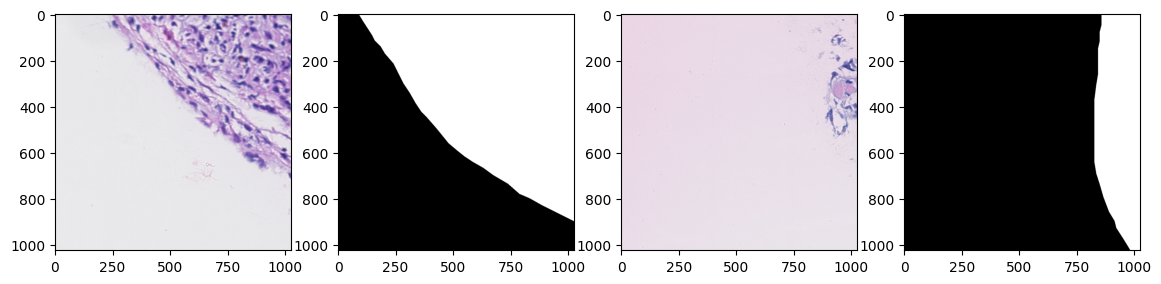

[0 3]
[0 2]


In [5]:
randTrainImgNum = random.randint(0, len(trainImgBatch)-1)
randValImgNum = random.randint(0, len(valImgBatch)-1)
print(randTrainImgNum)
print(randValImgNum)

trainImgExample = trainImgBatch[randTrainImgNum]
trainMaskExample = np.argmax(trainMaskBatch[randTrainImgNum], axis=2)

valImgExample = valImgBatch[randValImgNum]
valMaskExample = np.argmax(valMaskBatch[randValImgNum], axis=2)

plt.figure(figsize=(14,10))
plt.subplot(141)
plt.imshow(trainImgExample.astype('uint8'))
plt.subplot(142)
plt.imshow(trainMaskExample, cmap='gray')
plt.subplot(143)
plt.imshow(valImgExample.astype('uint8'))
plt.subplot(144)
plt.imshow(valMaskExample, cmap='gray')
plt.show()
print(np.unique(trainMaskExample))
print(np.unique(valMaskExample))

# CNN Models

## U-Net Model - ResNet34 Architecture

### Training

In [ ]:
# U-Net Model - ResNet50 Backbone
tf.compat.v1.disable_eager_execution()

optimizer='adam'
loss = sm.losses.jaccard_loss
metric = [sm.metrics.iou_score, 'acc']
tensorboard = keras.callbacks.TensorBoard(log_dir=os.path.join(os.getcwd(),'Tensorboard','Multiclass','uNet','ResNet34'))
callbacks_list = [keras.callbacks.ModelCheckpoint(filepath=os.path.join(os.getcwd(),'Saved Models','Multiclass','uNet_ResNet34_model.hdf5'),
                                                  monitor='val_loss', mode='min',
                                                  save_best_only=True), tensorboard]

resnet34_uNetModel = sm.Unet(backbone_name = resNet34_backbone, activation = 'softmax', classes = numClasses)
resnet34_uNetModel.summary()

resnet34_uNetModel.compile(optimizer=optimizer, loss=loss, metrics=metric)

numTrainImgs = len(os.listdir(os.path.join(trainImgPath,'train')))
numValImgs = len(os.listdir(os.path.join(valImgPath,'val')))
trainStepsPerEpoch = numTrainImgs//batchSize
valStepsPerEpoch = numValImgs//batchSize

resnet34_uNetModel_history = resnet34_uNetModel.fit(resNet34_trainDataGen,
                                  steps_per_epoch=trainStepsPerEpoch,
                                  epochs=150,
                                  callbacks=callbacks_list,
                                  validation_data=resNet34_valDataGen,
                                  validation_steps=valStepsPerEpoch)

### Evaluating

In [4]:
resnet34_uNetModel = keras.models.load_model('/Users/ahn/Documents/RUC/Kandidat/4 Semester/Thesis/Notebook/CardiacBiopsyDL/Saved Models/Multiclass/uNet_ResNet34_model.hdf5', compile=False)

optimizer='adam'
loss = sm.losses.jaccard_loss
metric = [sm.metrics.iou_score,'acc']
resnet34_uNetModel.compile(optimizer=optimizer, loss=loss, metrics=metric)

Metal device set to: AMD Radeon Pro 555


2022-09-28 19:31:46.013478: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-28 19:31:46.014171: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
resnet34_valSteps = len(os.listdir(os.path.join(valImgPath,'val')))//batchSize
resnet34_uNetModel.evaluate_generator(resNet34_valDataGen, resnet34_valSteps)

/var/folders/55/xgkxn7g91cqfk7tzx2ptcvr80000gn/T/ipykernel_1106/2031521906.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  resnet34_uNetModel.evaluate_generator(resNet34_valDataGen, resnet34_valSteps)


Found 250 images belonging to 1 classes.
Found 250 images belonging to 1 classes.


2022-09-28 11:43:59.072860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[0.5915820598602295, 0.40841782093048096, 0.6411696076393127]

In [6]:
resnet34_testSteps = len(os.listdir(os.path.join(testImgPath,'test')))//batchSize
resnet34_uNetModel.evaluate_generator(resNet34_testDataGen, resnet34_testSteps)

/var/folders/55/xgkxn7g91cqfk7tzx2ptcvr80000gn/T/ipykernel_1106/1859439470.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  resnet34_uNetModel.evaluate_generator(resNet34_testDataGen, resnet34_testSteps)


Found 126 images belonging to 1 classes.
Found 126 images belonging to 1 classes.


[0.585850179195404, 0.41414976119995117, 0.6472729444503784]

In [ ]:
resnet34_uNetModel_epochs = range(1, len(resnet34_uNetModel_history.history['loss']) + 1)
resnet34_uNetModel_loss = resnet34_uNetModel_history.history['loss']
resnet34_uNetModel_valLoss = resnet34_uNetModel_history.history['val_loss']

plt.figure()
plt.plot(resnet34_uNetModel_epochs, resnet34_uNetModel_loss, color='red', label='Training loss')
plt.plot(resnet34_uNetModel_epochs, resnet34_uNetModel_valLoss, color='green', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

In [ ]:
resnet34_uNetModel_epochs = range(1, len(resnet34_uNetModel_history.history['loss']) + 1)
resnet34_uNetModel_IoUscore = resnet34_uNetModel_history.history['iou_score']
resnet34_uNetModel_valIoUscore = resnet34_uNetModel_history.history['val_iou_score']

plt.plot(resnet34_uNetModel_epochs, resnet34_uNetModel_IoUscore, color='red', label='Training IoU score')
plt.plot(resnet34_uNetModel_epochs, resnet34_uNetModel_valIoUscore, color='green', label='Validation IoU score')
plt.title('Training and validation IoU score')
plt.legend()

In [ ]:
resnet34_uNetModel_epochs = range(1, len(resnet34_uNetModel_history.history['loss']) + 1)
resnet34_uNetModel_acc = resnet34_uNetModel_history.history['acc']
resnet34_uNetModel_valacc = resnet34_uNetModel_history.history['val_acc']

plt.figure()
plt.plot(resnet34_uNetModel_epochs, resnet34_uNetModel_acc, color='red', label='Training acc')
plt.plot(resnet34_uNetModel_epochs, resnet34_uNetModel_valacc, color='green', label='Validation acc')
plt.title('Training and validation Accuracy')
plt.legend()

### Testing

In [33]:
resNet34_testImgBatch, resNet34_testMaskBatch = resNet34_testDataGen.__next__()
predictTestImg = resnet34_uNetModel.predict(resNet34_testImgBatch)

print('trainImgs array shape: ', resNet34_testImgBatch.shape)
print('trainMasks array shape: ', resNet34_testMaskBatch.shape)

1/1 [==============================] - 1s 1s/step
trainImgs array shape:  (2, 1024, 1024, 3)
trainMasks array shape:  (2, 1024, 1024, 4)


0


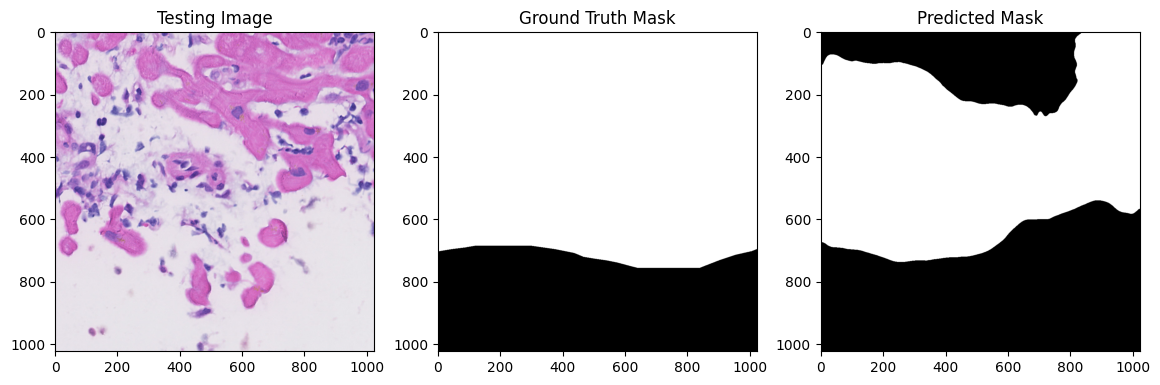

[0 2]
[0 2]


In [34]:
#Test some random images from
randTestImgNum = random.randint(0, len(resNet34_testImgBatch)-1)
print(randTestImgNum)
testImg = resNet34_testImgBatch[randTestImgNum]
groundTruthMask =  np.argmax(resNet34_testMaskBatch[randTestImgNum], axis=2)
predictedMask = np.argmax(predictTestImg[randTestImgNum], axis=2)

plt.figure(figsize=(14, 10))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(testImg.astype('uint8'))
plt.subplot(232)
plt.title('Ground Truth Mask')
plt.imshow(groundTruthMask, cmap='gray')
plt.subplot(233)
plt.title('Predicted Mask')
plt.imshow(predictedMask, cmap='gray')
plt.show()
print(np.unique(groundTruthMask))
print(np.unique(predictedMask))

## U-Net Model - VGG16 Architecture

### Training

In [ ]:
# U-Net Model - VGG19 Backbone
tf.compat.v1.disable_eager_execution()

optimizer='adam'
loss = sm.losses.jaccard_loss
metric = [sm.metrics.iou_score,'acc']
tensorboard = keras.callbacks.TensorBoard(log_dir=os.path.join(os.getcwd(),'Tensorboard','Multiclass','uNet','VGG16'))
callbacks_list = [keras.callbacks.ModelCheckpoint(filepath=os.path.join(os.getcwd(),'Saved Models','Multiclass','uNet_VGG16_model.hdf5'),
                                                  monitor='val_loss', mode='min',
                                                  save_best_only=True), tensorboard]

vgg16_uNetModel = sm.Unet(backbone_name = vgg16_backbone, activation = 'softmax', classes = numClasses)
vgg16_uNetModel.summary()

vgg16_uNetModel.compile(optimizer=optimizer, loss=loss, metrics=metric)

numTrainImgs = len(os.listdir(os.path.join(trainImgPath,'train')))
numValImgs = len(os.listdir(os.path.join(valImgPath,'val')))
trainStepsPerEpoch = numTrainImgs//batchSize
valStepsPerEpoch = numValImgs//batchSize

vgg16_uNetModel_history = vgg16_uNetModel.fit(vgg16_trainDataGen,
                                  steps_per_epoch=trainStepsPerEpoch,
                                  epochs=150,
                                  callbacks=callbacks_list,
                                  validation_data=vgg16_valDataGen,
                                  validation_steps=valStepsPerEpoch)

### Evaluating

In [35]:
vgg16_uNetModel = keras.models.load_model('/Users/ahn/Documents/RUC/Kandidat/4 Semester/Thesis/Notebook/CardiacBiopsyDL/Saved Models/Multiclass/uNet_VGG16_model.hdf5', compile=False)

optimizer='adam'
loss = sm.losses.jaccard_loss
metric = [sm.metrics.iou_score,'acc']
vgg16_uNetModel.compile(optimizer=optimizer, loss=loss, metrics=metric)

In [9]:
vgg16_valSteps = len(os.listdir(os.path.join(valImgPath,'val')))//batchSize
vgg16_uNetModel.evaluate_generator(vgg16_valDataGen, vgg16_valSteps)

/var/folders/55/xgkxn7g91cqfk7tzx2ptcvr80000gn/T/ipykernel_1203/3732150307.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  vgg16_uNetModel.evaluate_generator(vgg16_valDataGen, vgg16_valSteps)


Found 250 images belonging to 1 classes.
Found 250 images belonging to 1 classes.


2022-09-28 12:08:56.265781: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[0.729448676109314, 0.2705513536930084, 0.6306376457214355]

In [11]:
vgg16_testSteps = len(os.listdir(os.path.join(testImgPath,'test')))//batchSize
vgg16_uNetModel.evaluate_generator(vgg16_testDataGen, vgg16_testSteps)

/var/folders/55/xgkxn7g91cqfk7tzx2ptcvr80000gn/T/ipykernel_1203/3769072204.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  vgg16_uNetModel.evaluate_generator(vgg16_testDataGen, vgg16_testSteps)


Found 126 images belonging to 1 classes.
Found 126 images belonging to 1 classes.


[0.7237190008163452, 0.27628093957901, 0.6213589310646057]

In [ ]:
vgg16_uNetModel_epochs = range(1, len(vgg16_uNetModel_history.history['loss']) + 1)
vgg16_uNetModel_loss = vgg16_uNetModel_history.history['loss']
vgg16_uNetModel_valLoss = vgg16_uNetModel_history.history['val_loss']

plt.figure()
plt.plot(vgg16_uNetModel_epochs, vgg16_uNetModel_loss, color='red', label='Training loss')
plt.plot(vgg16_uNetModel_epochs, vgg16_uNetModel_valLoss, color='green', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

In [ ]:
vgg16_uNetModel_epochs = range(1, len(vgg16_uNetModel_history.history['loss']) + 1)
vgg16_uNetModel_IoUscore = vgg16_uNetModel_history.history['iou_score']
vgg16_uNetModel_valIoUscore = vgg16_uNetModel_history.history['val_iou_score']

plt.figure()
plt.plot(vgg16_uNetModel_epochs, vgg16_uNetModel_IoUscore, color='red', label='Training IoU score')
plt.plot(vgg16_uNetModel_epochs, vgg16_uNetModel_valIoUscore, color='green', label='Validation IoU score')
plt.title('Training and validation IoU score')
plt.legend()

In [ ]:
vgg16_uNetModel_epochs = range(1, len(vgg16_uNetModel_history.history['loss']) + 1)
vgg16_uNetModel_acc = vgg16_uNetModel_history.history['acc']
vgg16_uNetModel_valAcc = vgg16_uNetModel_history.history['val_acc']

plt.figure()
plt.plot(vgg16_uNetModel_epochs, vgg16_uNetModel_acc, color='red', label='Training acc')
plt.plot(vgg16_uNetModel_epochs, vgg16_uNetModel_valAcc, color='green', label='Validation acc')
plt.title('Training and validation Accuracy')
plt.legend()

### Testing

In [43]:
vgg16_testImgBatch, vgg16_testMaskBatch = vgg16_testDataGen.__next__()
predictTestImg = vgg16_uNetModel.predict(vgg16_testImgBatch)

print('trainImgs array shape: ', vgg16_testImgBatch.shape)
print('trainMasks array shape: ', vgg16_testMaskBatch.shape)

1/1 [==============================] - 4s 4s/step
trainImgs array shape:  (2, 1024, 1024, 3)
trainMasks array shape:  (2, 1024, 1024, 4)


1


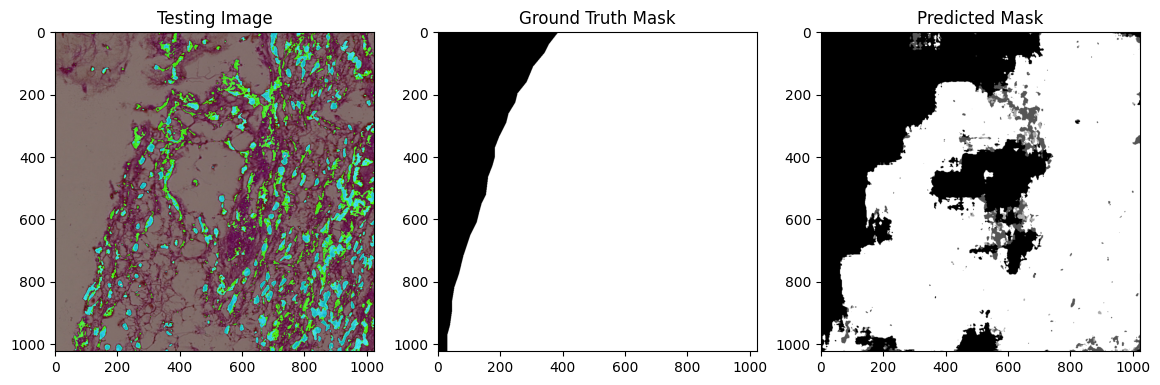

[0 3]
[0 1 2 3]


In [44]:
#Test some random images from
randTestImgNum = random.randint(0, len(vgg16_testImgBatch)-1)
print(randTestImgNum)
testImg = vgg16_testImgBatch[randTestImgNum]
groundTruthMask =  np.argmax(vgg16_testMaskBatch[randTestImgNum], axis=2)
predictedMask = np.argmax(predictTestImg[randTestImgNum], axis=2)

plt.figure(figsize=(14, 10))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(testImg.astype('uint8'))
plt.subplot(232)
plt.title('Ground Truth Mask')
plt.imshow(groundTruthMask, cmap='gray')
plt.subplot(233)
plt.title('Predicted Mask')
plt.imshow(predictedMask, cmap='gray')
plt.show()
print(np.unique(groundTruthMask))
print(np.unique(predictedMask))